# 고속열차 여객 수송자료 

교통 분야는 빅데이터의 수집과 분석이 가장 활발하게 진행되는 분야이다. 자동차, 항공기, 기차 등 교통 수단들이 운행할 때 다양한 형태의 빅데이터들이 생성되고 저장되고 있다. 최근에는 자율 주행차의 개발을 위하여 자동차 운행에 관련된 빅데이터 분석이 중요한 이슈이다. 또한 열차와 항공기 같은 여객 산업에서는 예약과 결제 등 서비스와 매출에 대한 빅데이터가 효율적인 자원 배분과 수익관리에 유용하게 사용된다. 

열차는 자동차,항공기와 다르게 출발역과 도착역 사이에 다수의 중간 정차역이 존재한다. 따라서 열차를 운행하는 경우 여행 경로에 따른 승객의 수요 예측과 죄석의 합리적인  배분이 매우 중요하다. 

예를 들어 KTX 고속 열차 노선 중에 서울에서 출발하여 부산에 도착하는 경부 하행선 열차가 하루에 60회 정도 운행한다. 중간 정차역이 적게는 5개, 많게는 8개인 것을 고려하면 여행 경로의 수는 상당히 많다. 그리고 운행하는 요일, 계절, 명절에 따라 수요가 다르므로 여객의 수요를 예측하고 좌석을 배정하는 작업은 매우 까다로운 작업이다. 더 나아가 경부선만 아닌 전라선, 영동선과 같은 다른 노선이 매일 운행하고 있고 상행/하행 두 노선을 모두 고려하면 상당한 빅데이터가 처리되고 분석되어야 한다.  


![ktx](../../images/ktx.jpeg)

이 예제에서는 한 달 동안 운행한 고속 열차에 탑승한 승객의 수송자료를 처리하고 기초적인 분석을 하는 예를 살펴 보기로 한다.


분석의 목표는 여행 구간마다 요일별 탑긍객 수가 어떤 패턴을 가지는 지 알아보는 것이다.   
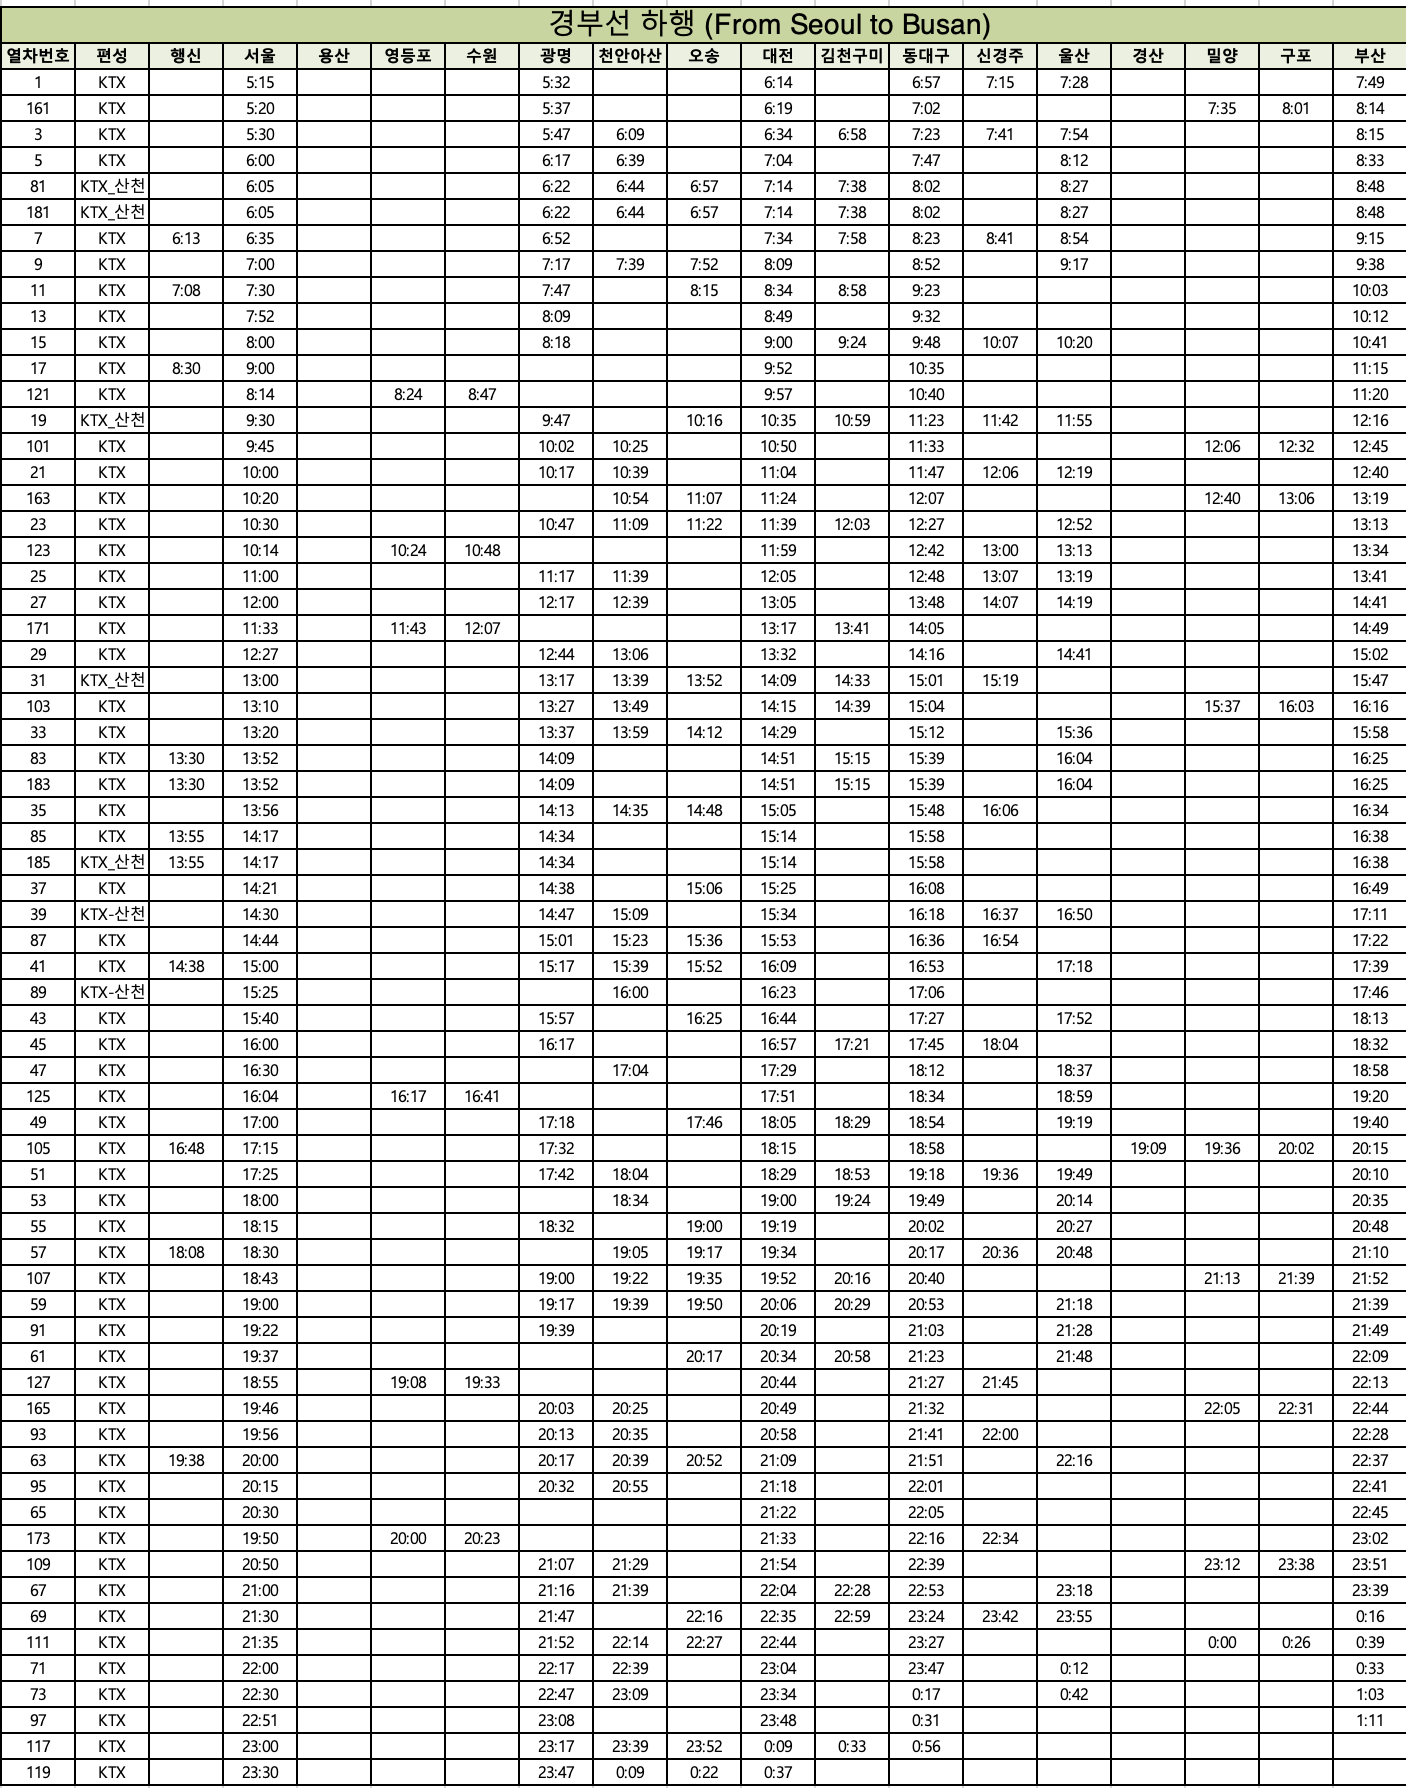

## 필요한 라이브러리

분석 결과를 이용하여 그림을 그리려면 다음과 같은 여러 개의 라이브러리를 불러와야 한다. 아래 라이브러리의 의미와 그림을 잘 그리기 위한 다양한 기능들은 뒤에서 자세하게 다룰 것이므로 이 예제에서는 일단 실행해보자.

In [166]:
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

rc('font', family='AppleGothic')  # mac os 에서만 필요, colab 에서는 불필요 
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.figsize"] = (10,5)

In [167]:
import pandas as pd

## 고속열차 수송 자료

고속 열차에 탑승한 승객에 대한 자료는 csv(comma-separated values) 형식으로 `train-data-01.csv` 화일에 저장되어 있다. csv 자료 화일의 각 열에 대한 이름과 설명은 다음과 같다.

- `TRAIN_NO`: 열차 번호
- `DATE` : 운행 일자
- `STATION_START`: 출발역
- `STATION_ARRV` : 도착역
- `NUM_PASSENGER` : 탑승객 수

`pandas` 라이브러리의 `read_csv()` 함수를 사용하면 csv 화일의 자료를 읽어서 데이터프레임으로 만들 수 있다.

In [168]:
train_raw_data = pd.read_csv("/Users/ylee19067/Dropbox/project/teaching/bigdata/textbook/book/data/train-data-01.csv")

이제 자료가 어떻게 구성되어 있는지 살펴보자.

In [169]:
train_raw_data

,TRAIN_NO,DATE,STATION_DEPART,STATION_ARRV,NUM_PASSENGER
0,2,20190701,서울,대전,106.0
1,2,20190702,서울,대전,113.0
2,2,20190703,서울,대전,146.0
3,2,20190704,서울,대전,84.0
4,2,20190705,서울,대전,105.0
...,...,...,...,...,...
1764,6,20190726,울산,부산,10.0
1765,6,20190727,울산,부산,6.0
1766,6,20190728,울산,부산,21.0
1767,6,20190729,울산,부산,12.0


일단 열차 수송 자료에 포함된 운행 열차의 수를 알아 보자. 아래에서 사용되는 `unique()` 함수는 시리즈 안에 있는 원소들을 중복이 없이 유일한 값만으로 출력해 주는 함수이다. 

자료에 포함된 운행열차의 번호는 2, 5, 6 번 열차임을 알 수 있다. 각 열차는 출발시간과 정차역이 다를 것이다.  

In [170]:
train_raw_data['TRAIN_NO']

0       2
1       2
2       2
3       2
4       2
       ..
1764    6
1765    6
1766    6
1767    6
1768    6
Name: TRAIN_NO, Length: 1769, dtype: int64

In [171]:
num_train = train_raw_data['TRAIN_NO'].unique()
num_train

array([2, 5, 6])

## 시계열 그림 

이제 2번 열차의 자료만 선택하여 서울-부산 구간에 탑승한 승객의 수가 날짜별로 어떻게 다른지 살펴보자.

먼저 원자료에서 다음 3개의 조건을 모두 만족하는 행들을 추출해야 한다.

1. 열차번호가 2번이다.
2. 출발역은 서울역이다.
3. 도착역은 부산역이다.

위의 조건을 구하는 참과 거짓으로 구성된 3개의 시리즈를 만들어 보자. 

In [172]:

select_condtion_1 = train_raw_data.TRAIN_NO == 2            # 열차번호가 2번인가?
select_condtion_3 = train_raw_data.STATION_DEPART == '서울'  # 출발역은 서울역인가?
select_condtion_2 = train_raw_data.STATION_ARRV == '부산'    # 도착역은 부산역인가?
select_condtion_1

0        True
1        True
2        True
3        True
4        True
        ...  
1764    False
1765    False
1766    False
1767    False
1768    False
Name: TRAIN_NO, Length: 1769, dtype: bool

이제 위에서 만든 3개의 조건을 보두 만족하는 조건을 나타내는 시리즈를 만든다. 3개의 조건이 모두 참인 것을 구하기 위해서는 아래 문장에서
비트단위연산자(bitwise operator)인 `&` 를 사용하였다. 비교하는 두 개체가 시리즈인 경우 논리연산자인 `and` 를 사용하지 않고  비트단위연산자  `&` 를 사용한다.

2번 열차의 서울-부산 구간에 탑승한 승객의 수는 데이터프레임 `train_2` 에 저장된다. 

In [173]:
select_condtion = select_condtion_1 & select_condtion_2 & select_condtion_3
select_condtion

0       False
1       False
2       False
3       False
4       False
        ...  
1764    False
1765    False
1766    False
1767    False
1768    False
Length: 1769, dtype: bool

In [174]:
train_2 = train_raw_data[ select_condtion ]
train_2

,TRAIN_NO,DATE,STATION_DEPART,STATION_ARRV,NUM_PASSENGER
60,2,20190701,서울,부산,613.0
61,2,20190702,서울,부산,546.0
62,2,20190703,서울,부산,492.0
63,2,20190704,서울,부산,615.0
64,2,20190705,서울,부산,572.0
65,2,20190706,서울,부산,598.0
66,2,20190707,서울,부산,326.0
67,2,20190708,서울,부산,552.0
68,2,20190709,서울,부산,540.0
69,2,20190710,서울,부산,499.0


In [175]:
train_2.dtypes

TRAIN_NO            int64
DATE                int64
STATION_DEPART     object
STATION_ARRV       object
NUM_PASSENGER     float64
dtype: object

이제 날짜별로 2번 열차의 서울-부산간 탑승자수를 나타내는 시계열 그림(time series plot)을 그려보자.

그림은 데이터프레임의 `plot()` 함수를 사용할 수 있으며 가로축(x)와 세로축(y)에 사용되는 열의 이름을 지정할 수 있다.

<AxesSubplot:xlabel='DATE'>

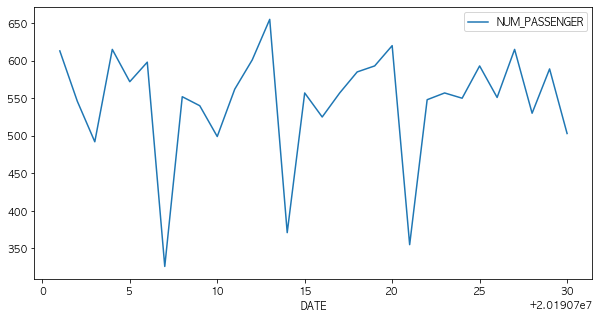

In [176]:
train_2.plot(x='DATE', y="NUM_PASSENGER")

위의 시계열 그림에서 주기적인 반복 패턴이 나타나고 있는 것을 알 수 있다. 즉, 요일에 따라서 탑승객 수의 차이가 난다는 의미이다.

위의 그림에서 나타나는 문제는 시간축, 즉 가로축(x)의 숫자가 날짜로 표시되지 않는다는 것이다. 이는 데이터프레임의 열 `DATE` 가 날짜를 나타내는 변수가 아닌 정수값을 가지는 시리즈이기 때문이다.

이제 데이터프레임에 날짜 형식을 가진 새로운 변수 `DATE2` 를 추가로 만들어 보자. 날짜 변수를 만드는 함수 `to_datetime()` 를 사용하여 `DATE` 열을 변환하여 
새로운 변수 `DATE2` 를 만든다.  여기서 함수 `to_datetime()` 의 옵션 `format='%Y%m%d'` 은 변환에 사용할 정수 자료의 형식이 `YYYYMMDD` 로 년,월,일을 연결하여 만든 숫자라고 알려주는 것이다. 

In [177]:
train_2['DATE2'] = pd.to_datetime(train_2['DATE'], format='%Y%m%d')
train_2

<ipython-input-177-9276ff3ebbfa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_2['DATE2'] = pd.to_datetime(train_2['DATE'], format='%Y%m%d')


,TRAIN_NO,DATE,STATION_DEPART,STATION_ARRV,NUM_PASSENGER,DATE2
60,2,20190701,서울,부산,613.0,2019-07-01
61,2,20190702,서울,부산,546.0,2019-07-02
62,2,20190703,서울,부산,492.0,2019-07-03
63,2,20190704,서울,부산,615.0,2019-07-04
64,2,20190705,서울,부산,572.0,2019-07-05
65,2,20190706,서울,부산,598.0,2019-07-06
66,2,20190707,서울,부산,326.0,2019-07-07
67,2,20190708,서울,부산,552.0,2019-07-08
68,2,20190709,서울,부산,540.0,2019-07-09
69,2,20190710,서울,부산,499.0,2019-07-10


<AxesSubplot:xlabel='DATE2'>

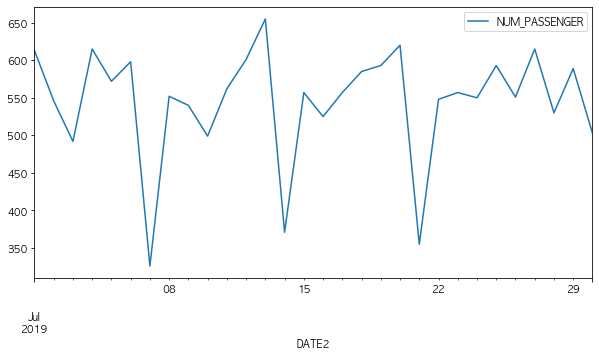

In [178]:
train_2.plot(x='DATE2', y="NUM_PASSENGER")

## 그룹별 분석 

위의 분석에서 나타난 것처럼 요일마다 탑승객의 수가 다르므로 **요일별, 구간별** 로 평균 탑승객 수를 구하여 비교해보려고 한다.  

먼저 앞에서 한 것과 같이 날짜의 형식을 가진 새로운 변수 `DATE2`를 데이터프레임에 추가하자.

In [179]:
train_raw_data['DATE2'] = pd.to_datetime(train_raw_data['DATE'], format='%Y%m%d')

In [180]:
train_raw_data

,TRAIN_NO,DATE,STATION_DEPART,STATION_ARRV,NUM_PASSENGER,DATE2
0,2,20190701,서울,대전,106.0,2019-07-01
1,2,20190702,서울,대전,113.0,2019-07-02
2,2,20190703,서울,대전,146.0,2019-07-03
3,2,20190704,서울,대전,84.0,2019-07-04
4,2,20190705,서울,대전,105.0,2019-07-05
...,...,...,...,...,...,...
1764,6,20190726,울산,부산,10.0,2019-07-26
1765,6,20190727,울산,부산,6.0,2019-07-27
1766,6,20190728,울산,부산,21.0,2019-07-28
1767,6,20190729,울산,부산,12.0,2019-07-29


In [181]:
train_raw_data.dtypes

TRAIN_NO                   int64
DATE                       int64
STATION_DEPART            object
STATION_ARRV              object
NUM_PASSENGER            float64
DATE2             datetime64[ns]
dtype: object

이제 날짜의 형식을 가진 변수 `DATE2` 를 아용하여 요일을 나타내는 새로운 변수 `DAYOFWEEK` 를 만들어 보자.

시리즈 `train_raw_data['DATE2']` 에 메소드 `dt.dayofweek` 를 적용하면 각 날짜에 대응하는 요일을 구해준다.  요일의 코딩 형식은 월요일이 0, 화요일이 1, 그리고 일요일이 6 으로 코딩된다.

In [182]:
train_raw_data['DAYOFWEEK'] =  train_raw_data['DATE2'].dt.dayofweek

In [183]:
train_raw_data

,TRAIN_NO,DATE,STATION_DEPART,STATION_ARRV,NUM_PASSENGER,DATE2,DAYOFWEEK
0,2,20190701,서울,대전,106.0,2019-07-01,0
1,2,20190702,서울,대전,113.0,2019-07-02,1
2,2,20190703,서울,대전,146.0,2019-07-03,2
3,2,20190704,서울,대전,84.0,2019-07-04,3
4,2,20190705,서울,대전,105.0,2019-07-05,4
...,...,...,...,...,...,...,...
1764,6,20190726,울산,부산,10.0,2019-07-26,4
1765,6,20190727,울산,부산,6.0,2019-07-27,5
1766,6,20190728,울산,부산,21.0,2019-07-28,6
1767,6,20190729,울산,부산,12.0,2019-07-29,0


이제 요일별, 구간별로 탑승객 수의 평균을 구하기 위하여 필요한 변수를 가진 데이터프레임을 먼저 만든다. 

요일별, 구간별 분석을 하려면 다음과 같은 3개의 변수(요일, 출발역, 도착역)로 자료를 그룹화(grouping)해야한다.

- `DAYOFWEEK`
- `STATION_DEPART`
- `STATION_ARRV` 


In [184]:
train_group_data = train_raw_data[ [ 'STATION_DEPART', 'STATION_ARRV','DAYOFWEEK','NUM_PASSENGER']]

In [185]:
train_group_data

,STATION_DEPART,STATION_ARRV,DAYOFWEEK,NUM_PASSENGER
0,서울,대전,0,106.0
1,서울,대전,1,113.0
2,서울,대전,2,146.0
3,서울,대전,3,84.0
4,서울,대전,4,105.0
...,...,...,...,...
1764,울산,부산,4,10.0
1765,울산,부산,5,6.0
1766,울산,부산,6,21.0
1767,울산,부산,0,12.0


이제 3개의 변수, 즉  `DAYOFWEEK`, `STATION_DEPART`, `STATION_ARRV` 의 값들로 전체 자료를 그룹화 하고 각 그룹에 속하는 탑승객수들의 평균을 구해보자.

이러힌 작업은 다음과 같은 2개의 함수를 제이터프레임에 **단계적으로** 적용하여 이루어진다.

1. `groupby()` 함수는 주어진 열들의 값의 조합에 따라서 전체 자료를 그룹화한다.
2. `mean()` 함수는 각 그룹에 대한 열들의 평균값을 구한다.


In [186]:
summary_data = train_data.groupby(['STATION_DEPART','STATION_ARRV','DAYOFWEEK']).mean()
summary_data 

NUM_PASSENGER
STATION_DEPART STATION_ARRV DAYOFWEEK               
광명             대전           0                 16.300
                            1                 15.200
                            2                 20.750
                            3                 21.125
                            4                 18.125
...                                              ...
행신             서울           2                 12.750
                            3                 10.000
                            4                  8.250
                            5                  7.500
                            6                  5.000

[224 rows x 1 columns]

위의 그룹화 결과자료는 그룹화에 사용되는 열들이 모두 행에 대한 인덱스로 표시되어 있다. 이러한 자료는 다루기가 까다로와서 각 그룹에 대한 값을 열로 다시 만들어 주는 것이 좋다.

이러한 작업을 하는 함수가 `reset_index()` 이며 옵셩 `inplace=True` 실제로 데이터프레임에 적용하라는 의미이다.

In [187]:
summary_data.reset_index(inplace=True)
summary_data

,STATION_DEPART,STATION_ARRV,DAYOFWEEK,NUM_PASSENGER
0,광명,대전,0,16.300
1,광명,대전,1,15.200
2,광명,대전,2,20.750
3,광명,대전,3,21.125
4,광명,대전,4,18.125
...,...,...,...,...
219,행신,서울,2,12.750
220,행신,서울,3,10.000
221,행신,서울,4,8.250
222,행신,서울,5,7.500


이제 원하는 출발역과 도착역을 선택하여 요일별 평균 탑승객 수를 살펴보자. 

아래는 서울에서 출발하여 부산에 도착하는 탑승객 수의 요일별 평균값을 구하고 그름으로 나타난 결과이다. 금요일이 다른 요일보다 현저하게 탑승객의 수가 많고 일요일이 다소 적다는 것을 알 수 있다. 

In [188]:
od_average = summary_data[ ( summary_data['STATION_DEPART'] == '서울' ) & ( summary_data['STATION_ARRV'] == '부산' )]
od_average

,STATION_DEPART,STATION_ARRV,DAYOFWEEK,NUM_PASSENGER
98,서울,부산,0,284.800000
99,서울,부산,1,284.266667
100,서울,부산,2,287.833333
101,서울,부산,3,319.500000
102,서울,부산,4,353.833333
103,서울,부산,5,311.166667
104,서울,부산,6,265.083333


<AxesSubplot:xlabel='DAYOFWEEK'>

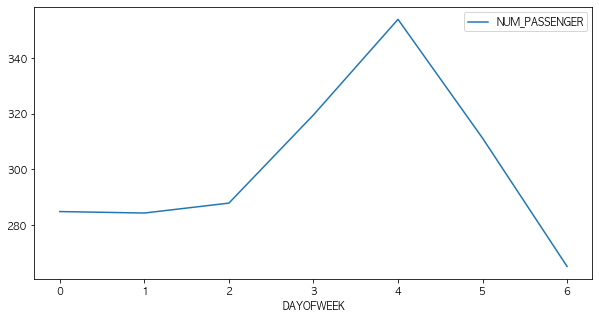

In [189]:
od_average.plot(x='DAYOFWEEK', y="NUM_PASSENGER")